In [2]:
# Import necessary libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import re

In [3]:
# Load the test dataset
test_df = pd.read_excel("../../data/Test_LLM.xlsx", index_col=[0])
test_df

,MID,title
0,M3062,Internet-based early intervention to prevent p...
1,M7694,Postdeployment suicidal ideations and trajecto...
2,M902,Maternal posttraumatic stress disorder symptom...
3,M6722,Trajectories of PTSD risk and resilience in Wo...
4,M11183,Latent trajectories of trauma symptoms and res...
...,...,...
293,M10369,Time-course analysis of frontal gene expressio...
294,M6107,Treatment outcomes of Veteran men in a compreh...
295,M10364,Altered Resting-State functional connectivity ...
296,M10348,Psychosocial and Physical Rehabilitation of Bu...


In [4]:
# Load the benchmark dataset
benchmark = pd.read_excel("../../data/Title_Simulation.xlsx", index_col=[0])
benchmark

,MID,title,label
0,M3062,Internet-based early intervention to prevent p...,1
1,M7694,Postdeployment suicidal ideations and trajecto...,1
2,M902,Maternal posttraumatic stress disorder symptom...,1
3,M6722,Trajectories of PTSD risk and resilience in Wo...,1
4,M11183,Latent trajectories of trauma symptoms and res...,1
...,...,...,...
293,M10369,Time-course analysis of frontal gene expressio...,0
294,M6107,Treatment outcomes of Veteran men in a compreh...,1
295,M10364,Altered Resting-State functional connectivity ...,0
296,M10348,Psychosocial and Physical Rehabilitation of Bu...,1


In [5]:
# Load the abstract benchmark dataset
abs_benchmark = pd.read_excel("../../data/Abstract_Simulation.xlsx", index_col=[0])
abs_benchmark

,MID,title,label
0,M3062,Internet-based early intervention to prevent p...,1
1,M7694,Postdeployment suicidal ideations and trajecto...,1
2,M902,Maternal posttraumatic stress disorder symptom...,1
3,M6722,Trajectories of PTSD risk and resilience in Wo...,1
4,M11183,Latent trajectories of trauma symptoms and res...,1
...,...,...,...
293,M10369,Time-course analysis of frontal gene expressio...,0
294,M6107,Treatment outcomes of Veteran men in a compreh...,0
295,M10364,Altered Resting-State functional connectivity ...,0
296,M10348,Psychosocial and Physical Rehabilitation of Bu...,0


In [4]:
# Ollama API url
url = "insert your own url"

In [38]:
# Create a function to run prompts that asks to label a test dataset and outputs the final labelled dataset
# https://github.com/ollama/ollama/blob/main/docs/api.md#generate-a-completion

def run_prompt(model, prompt_file, df_in, df_out, options=None, system=None, context=None, raw=False, keep_alive='5m'):

    # Empty list to store the response for each title
    responses = []

    # Load the prompt
    try:
        with open(prompt_file, 'r') as file:
            prompt = file.read()
    
    except FileNotFoundError:
        print(f"File '{prompt_file}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")
    
    file.close()

    # Copy the test dataset
    output_df = df_in

    # Run the prompt once for each title of the test dataset
    for title in test_df['title']:
        payload = {
            "model": model,
            "prompt": prompt + '"' + title + '"',
            "stream": False}

        # Include optional parameters if they are provided
        if options is not None:
            payload["options"] = options
        if system is not None:
            payload["system"] = system
        if context is not None:
            payload["context"] = context
        if raw is not False:
            payload["raw"] = True
        if keep_alive != '5m':
            payload["keep_alive"] = keep_alive

        # Sending the POST request
        response = requests.post(url, json=payload)

        # Append the response in the responses list
        responses.append(response.json()['response'])

    # Add the responses in the list in a new empty column for the labels in the output dataset
    output_df.loc[:,'label'] = responses

    # Save the labeled dataset 
    output_df.to_excel(df_out)

    # Calculate how fast the response is generated in tokens per second (token/s)
    time_to_respond = response.json()['eval_count'] / response.json()['eval_duration'] * 10**9

    print(time_to_respond, "tokens per second")

In [7]:
# Create a function to automate the prompt evaluation by comparing it to the humanly labelled dataset as a benchmark
def evaluate_prompt(dataset, benchmark):
    
    # Load the dataset
    df = pd.read_excel(dataset)
    
    # Plot the confusion matrix
    confusion_matrix = metrics.confusion_matrix(benchmark['label'], df['label'])
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Excluded', 'Included'])
    cm_display.plot(cmap=plt.cm.Blues)
    
    return plt.show()

In [8]:
# Create a function to calculate the recall
def get_recall(dataset, benchmark):

    # Load the dataset
    df = pd.read_excel(dataset)

    # Calculate recall
    recall = metrics.recall_score(benchmark['label'], df['label'])
    
    return recall

# Attempt 1

In [40]:
run_prompt(
    model = "llama3:8b", 
    prompt_file = "prompt1.txt", 
    df_in = test_df, 
    df_out = "Labels_Llama3_8b_1.xlsx", 
    options = {"seed": 42, "temperature": 0}  # for reproducible outputs, set temperature to 0 and seed to a number
    )

141.49274849663956 tokens per second


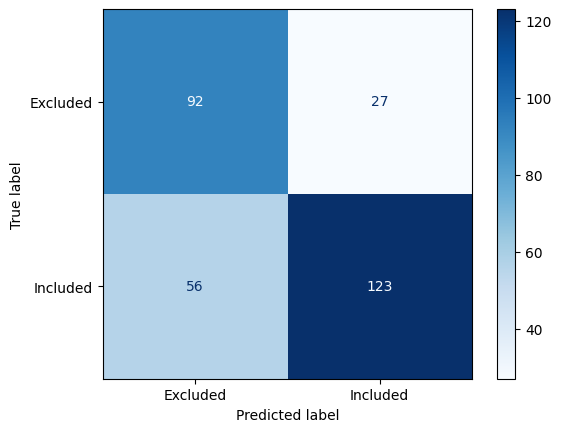

In [42]:
# Compare the model's labels with the human title labels
evaluate_prompt("Labels_Llama3_8b_1.xlsx", benchmark)

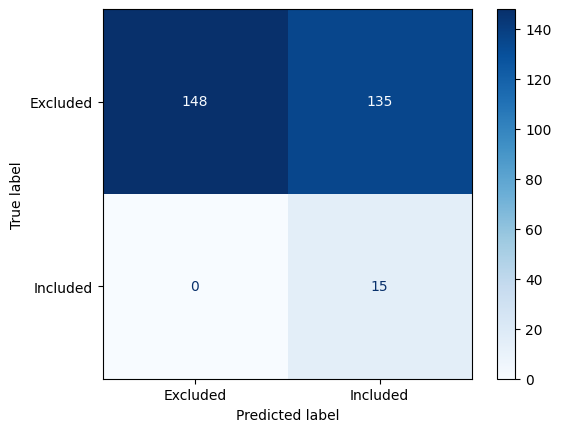

In [120]:
# Compare the model's labels with the human abstract labels
evaluate_prompt("Labels_Llama3_8b_1.xlsx", abs_benchmark)

# Attempt 2
Give priorities to the inclusion criteria

In [43]:
run_prompt(
    model = "llama3:8b", 
    prompt_file = "prompt2.txt", 
    df_in = test_df, 
    df_out = "Labels_Llama3_8b_2.xlsx", 
    options = {"seed": 42, "temperature": 0}  # for reproducible outputs, set temperature to 0 and seed to a number
    )

142.673705236125 tokens per second


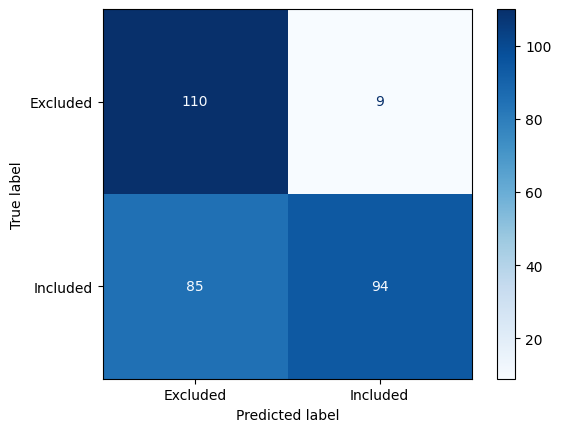

In [44]:
# Compare the model's labels with the human title labels
evaluate_prompt("Labels_Llama3_8b_2.xlsx", benchmark)

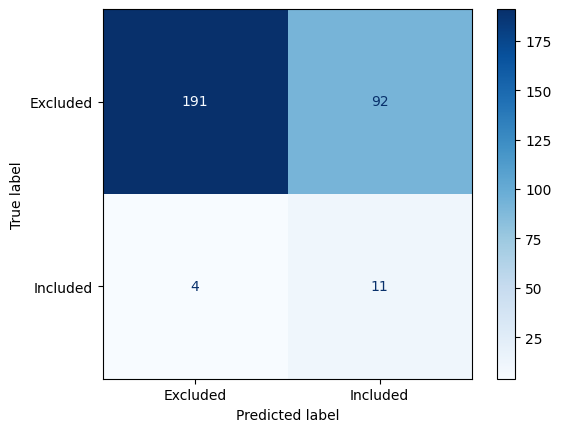

In [112]:
# Compare the model's labels with the human abstract labels
evaluate_prompt("Labels_Llama3_8b_2.xlsx", abs_benchmark)

# Attempt 3.1
Give emphasis on being lenient inside the prompt

142.35888675350557 tokens per second


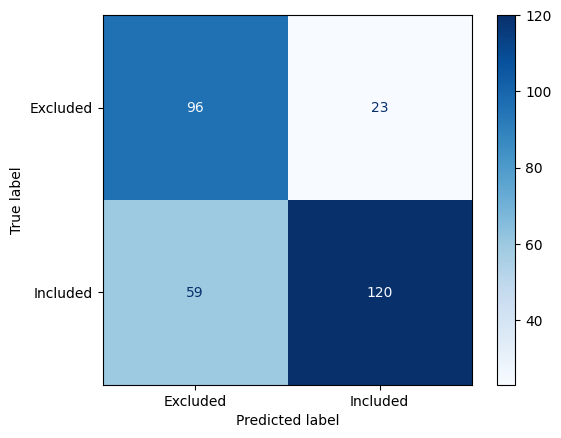

In [34]:
run_prompt(
    model = "llama3:8b", 
    prompt_file = "prompt3.txt", 
    df_in = test_df, 
    df_out = "Labels_Llama3_8b_3.1.xlsx", 
    options = {"seed": 42, "temperature": 0}  # for reproducible outputs, set temperature to 0 and seed to a number
    )

# Compare the model's labels with the human title labels
evaluate_prompt("Labels_Llama3_8b_3.1.xlsx", benchmark)

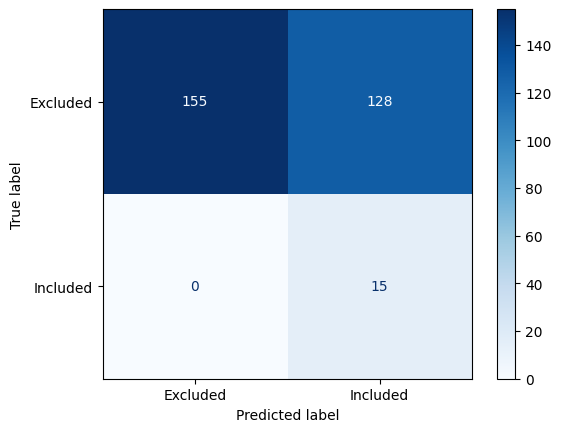

In [111]:
# Compare the model's labels with the human abstract labels
evaluate_prompt("Labels_Llama3_8b_3.1.xlsx", abs_benchmark)

# Attempt 3.2
Give emphasis on being lenient both inside the prompt and the "system" parameter

141.8540322008653 tokens per second


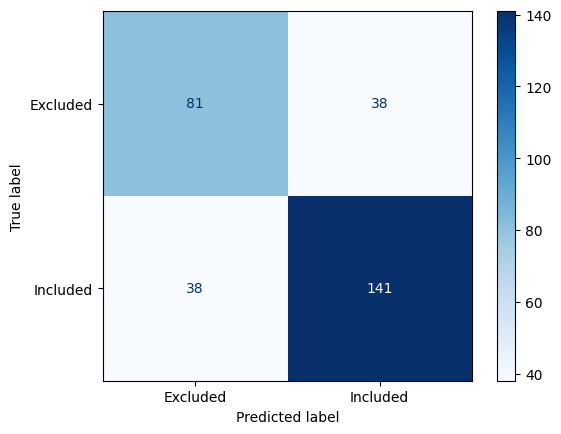

In [52]:
run_prompt(
    model = "llama3:8b", 
    prompt_file = "prompt3.txt", 
    df_in = test_df, 
    df_out = "Labels_Llama3_8b_3.2.xlsx", 
    options = {"seed": 42, "temperature": 0},  # for reproducible outputs, set temperature to 0 and seed to a number
    system = "You need to be lenient. You need to minimize the number of false negatives as much as possible."  # the system parameter is used to induce a specific type of behavior in the model
    )

# Compare the model's labels with the human title labels
evaluate_prompt("Labels_Llama3_8b_3.2.xlsx", benchmark)

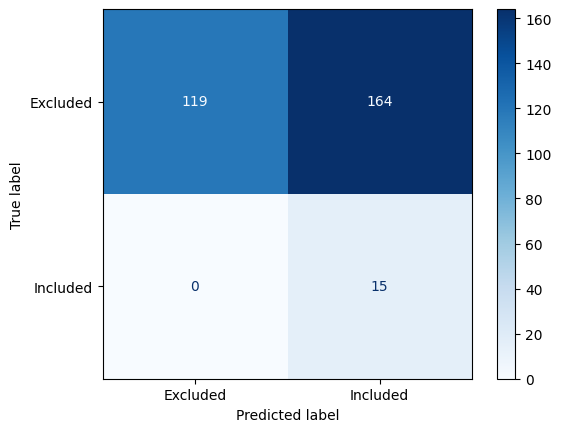

In [9]:
# Compare the model's labels with the human abstract labels
evaluate_prompt("Labels_Llama3_8b_3.2.xlsx", abs_benchmark)

# Attempt 4
Give emphasis on being conservative in capital letters

142.09591474245116 tokens per second


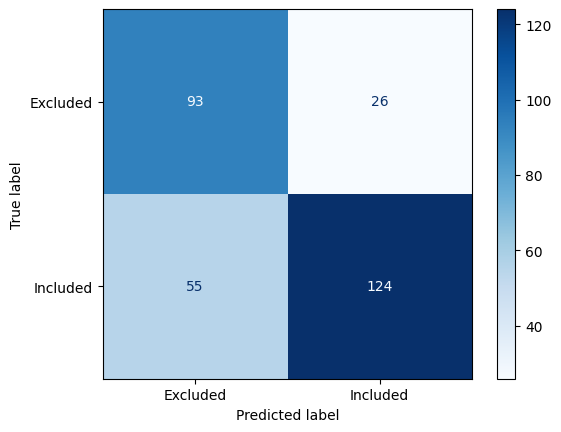

In [53]:
run_prompt(
    model = "llama3:8b", 
    prompt_file = "prompt4.txt", 
    df_in = test_df, 
    df_out = "Labels_Llama3_8b_4.xlsx", 
    options = {"seed": 42, "temperature": 0},  # for reproducible outputs, set temperature to 0 and seed to a number
    )

# Compare the model's labels with the human title labels
evaluate_prompt("Labels_Llama3_8b_4.xlsx", benchmark)

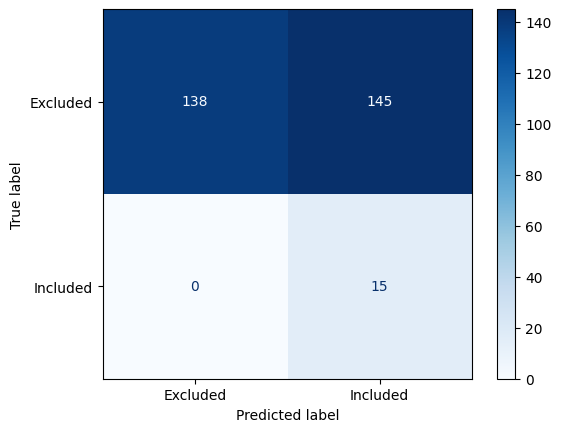

In [110]:
# Compare the model's labels with the human abstract labels
evaluate_prompt("Labels_Llama3_8b_4.xlsx", abs_benchmark)

# Attempt 5
Add more instructions on being conservative in the "system" parameter

141.1333004022299 tokens per second


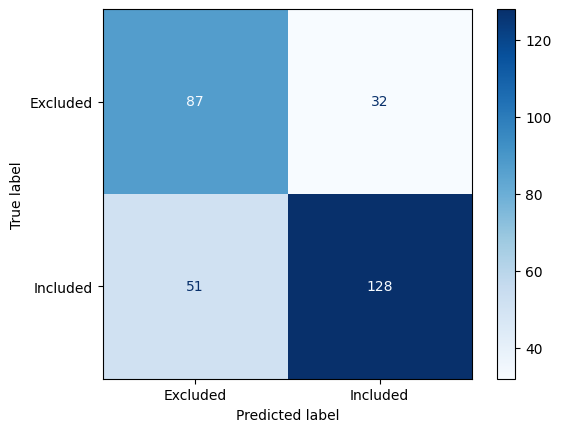

In [55]:
run_prompt(
    model = "llama3:8b", 
    prompt_file = "prompt5.txt", 
    df_in = test_df, 
    df_out = "Labels_Llama3_8b_5.xlsx", 
    options = {"seed": 42, "temperature": 0},  # for reproducible outputs, set temperature to 0 and seed to a number
    system = "Be conservative. If you find an ambiguous title, it is better to include it: I prefer including papers by mistake rather than excluding them by mistake. You want to have as little false negatives as possible."
    )

# Compare the model's labels with the human title labels
evaluate_prompt("Labels_Llama3_8b_5.xlsx", benchmark)

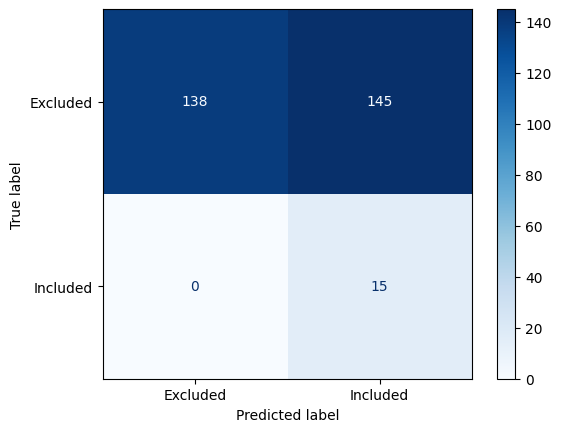

In [109]:
# Compare the model's labels with the human abstract labels
evaluate_prompt("Labels_Llama3_8b_5.xlsx", abs_benchmark)

# Attempt 6.1
Be redundant on being conservative both in the prompt and in the "system" parameter

139.19821826280622 tokens per second


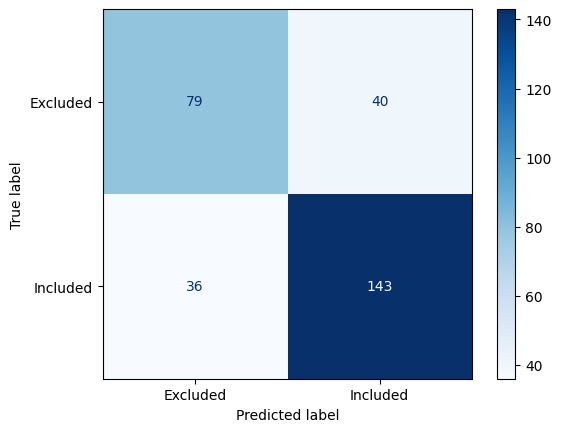

In [56]:
run_prompt(
    model = "llama3:8b", 
    prompt_file = "prompt6.txt", 
    df_in = test_df, 
    df_out = "Labels_Llama3_8b_6.1.xlsx", 
    options = {"seed": 42, "temperature": 0},  # for reproducible outputs, set temperature to 0 and seed to a number
    system = "Be conservative. If you find an ambiguous title, it is better to include it: I prefer including papers by mistake rather than excluding them by mistake. You want to have as little false negatives as possible."
    )

# Compare the model's labels with the human title labels
evaluate_prompt("Labels_Llama3_8b_6.1.xlsx", benchmark)

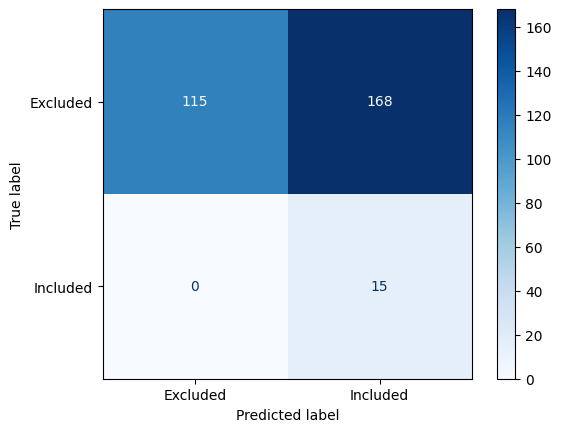

In [10]:
# Compare the model's labels with the human abstract labels
evaluate_prompt("Labels_Llama3_8b_6.1.xlsx", abs_benchmark)

# Attempt 6.2
Add a role in the "system" parameter

In [ ]:
run_prompt(
    model = "llama3:8b", 
    prompt_file = "prompt6.txt", 
    df_in = test_df, 
    df_out = "Labels_Llama3_8b_6.2.xlsx", 
    options = {"seed": 42, "temperature": 0},  # for reproducible outputs, set temperature to 0 and seed to a number
    system = "You are a researcher conducting a systematic review. Be conservative. If you find an ambiguous title, it is better to include it: I prefer including papers by mistake rather than excluding them by mistake. You want to have as little false negatives as possible."
    )

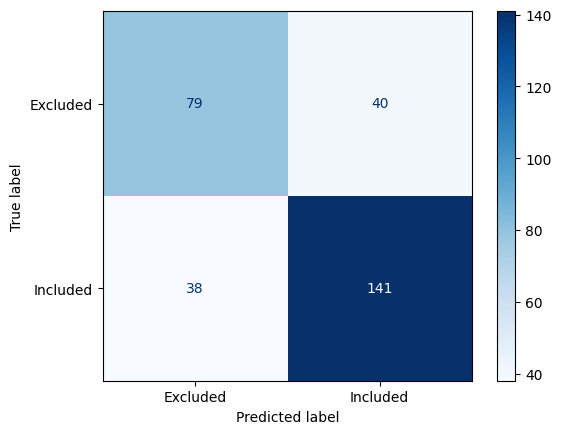

In [11]:
# Compare the model's labels with the human title labels
evaluate_prompt("Labels_Llama3_8b_6.2.xlsx", benchmark)

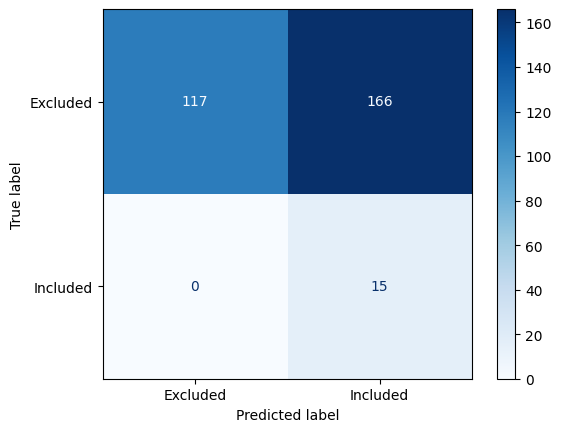

In [12]:
# Compare the model's labels with the human abstract labels
evaluate_prompt("Labels_Llama3_8b_6.2.xlsx", abs_benchmark)

# Attempt 7
Use contraries (e.g. "exclude" —> "do not include", "do not exclude" —> "include")

140.34102869974038 tokens per second


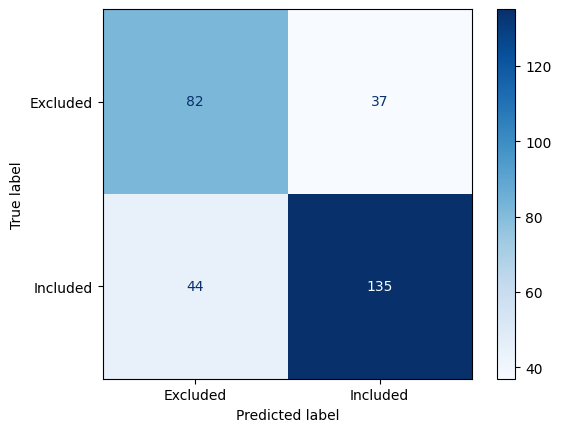

In [58]:
run_prompt(
    model = "llama3:8b", 
    prompt_file = "prompt7.txt", 
    df_in = test_df, 
    df_out = "Labels_Llama3_8b_7.xlsx", 
    options = {"seed": 42, "temperature": 0},  # for reproducible outputs, set temperature to 0 and seed to a number
    system = "Be conservative. If you find an ambiguous title, it is better to include it: I prefer including papers by mistake rather than excluding them by mistake. You want to have as little false negatives as possible."
    )

# Compare the model's labels with the human title labels
evaluate_prompt("Labels_Llama3_8b_7.xlsx", benchmark)

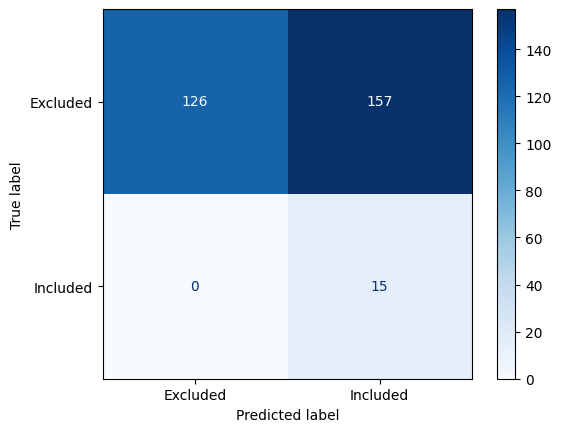

In [108]:
# Compare the model's labels with the human abstract labels
evaluate_prompt("Labels_Llama3_8b_7.xlsx", abs_benchmark)

# Attempt 8
Write the including criteria before the excluding criteria

139.91884706870016 tokens per second


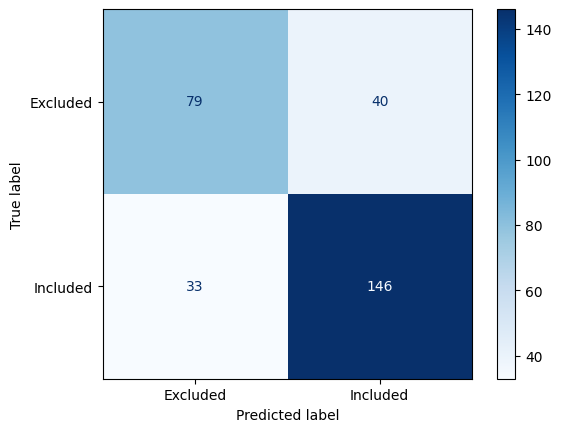

In [59]:
run_prompt(
    model = "llama3:8b", 
    prompt_file = "prompt8.txt", 
    df_in = test_df, 
    df_out = "Labels_Llama3_8b_8.xlsx", 
    options = {"seed": 42, "temperature": 0},  # for reproducible outputs, set temperature to 0 and seed to a number
    system = "Be conservative. If you find an ambiguous title, it is better to include it: I prefer including papers by mistake rather than excluding them by mistake. You want to have as little false negatives as possible."
    )

# Compare the model's labels with the human title labels
evaluate_prompt("Labels_Llama3_8b_8.xlsx", benchmark)

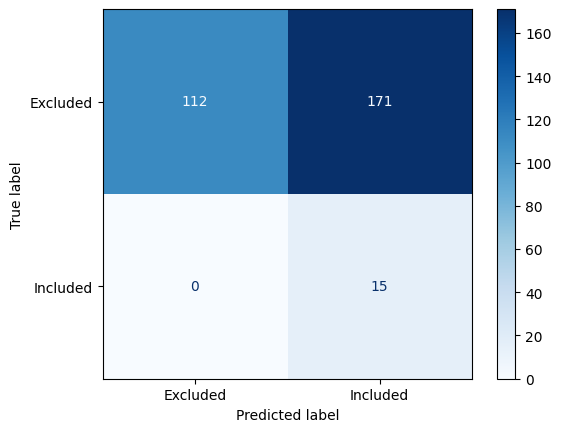

In [13]:
# Compare the model's labels with the human abstract labels
evaluate_prompt("Labels_Llama3_8b_8.xlsx", abs_benchmark)

# Attempt 9
Set priorities in the prompt, but with the reversed order tried in prompt 8

141.42271248762552 tokens per second


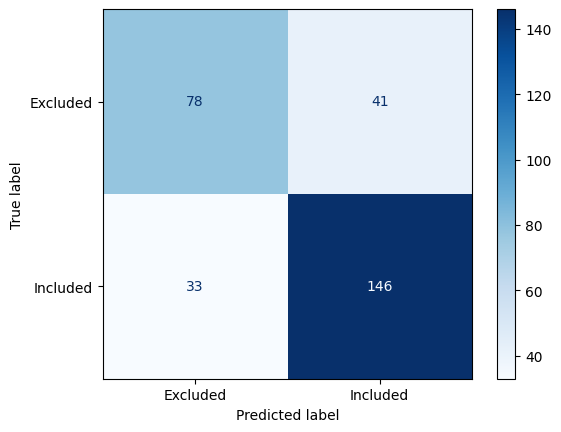

In [60]:
run_prompt(
    model = "llama3:8b", 
    prompt_file = "prompt9.txt", 
    df_in = test_df, 
    df_out = "Labels_Llama3_8b_9.xlsx", 
    options = {"seed": 42, "temperature": 0},  # for reproducible outputs, set temperature to 0 and seed to a number
    system = "Be conservative. If you find an ambiguous title, it is better to include it: I prefer including papers by mistake rather than excluding them by mistake. You want to have as little false negatives as possible."
    )

# Compare the model's labels with the human title labels
evaluate_prompt("Labels_Llama3_8b_9.xlsx", benchmark)

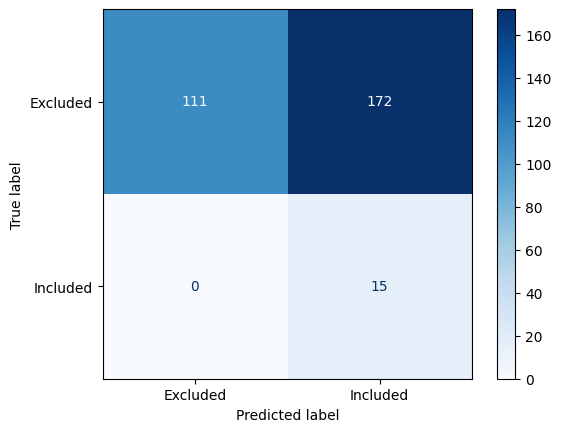

In [14]:
# Compare the model's labels with the human abstract labels
evaluate_prompt("Labels_Llama3_8b_9.xlsx", abs_benchmark)

# Attempt 10
Give priorities in the "system" parameter

141.28284826222097 tokens per second


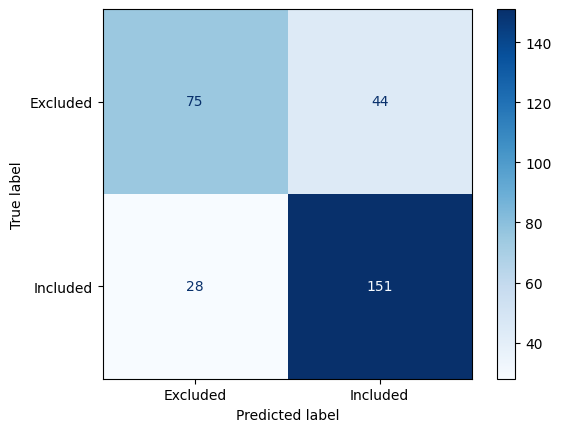

In [62]:
run_prompt(
    model = "llama3:8b", 
    prompt_file = "prompt10.txt", 
    df_in = test_df, 
    df_out = "Labels_Llama3_8b_10.xlsx", 
    options = {"seed": 42, "temperature": 0},  # for reproducible outputs, set temperature to 0 and seed to a number
    system = "Be conservative. If you find an ambiguous title, it is better to include it: I prefer including papers by mistake rather than excluding them by mistake. You want to have as little false negatives as possible. Step 1 has the priority over step 2."
    )

# Compare the model's labels with the human title labels
evaluate_prompt("Labels_Llama3_8b_10.xlsx", benchmark)

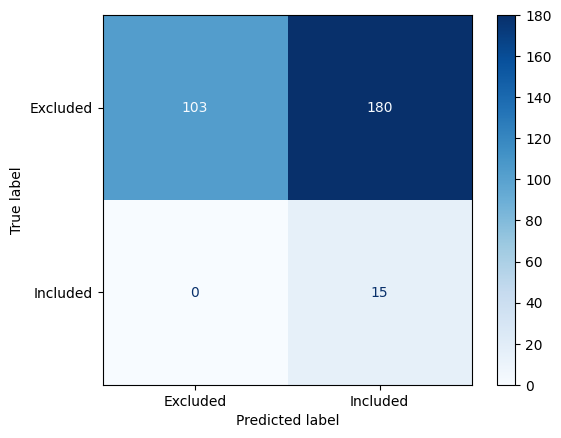

In [15]:
# Compare the model's labels with the human abstract labels
evaluate_prompt("Labels_Llama3_8b_10.xlsx", abs_benchmark)

# Attempt 11
Name "Step 1" and "Step 2" as "Inclusion criteria" and "Exclusion criteria" respectively

142.05554371759357 tokens per second


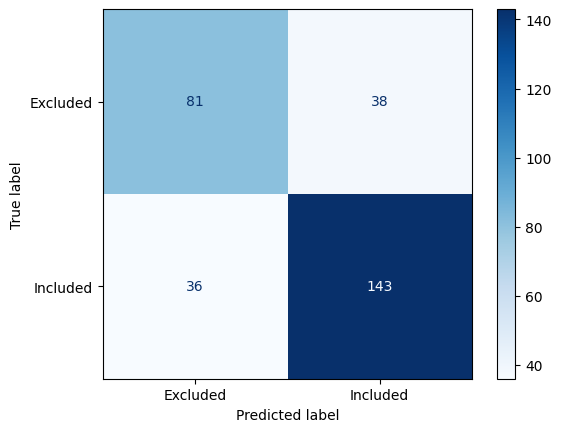

In [63]:
run_prompt(
    model = "llama3:8b", 
    prompt_file = "prompt11.txt", 
    df_in = test_df, 
    df_out = "Labels_Llama3_8b_11.xlsx", 
    options = {"seed": 42, "temperature": 0},  # for reproducible outputs, set temperature to 0 and seed to a number
    system = "Be conservative. If you find an ambiguous title, it is better to include it: I prefer including papers by mistake rather than excluding them by mistake. You want to have as little false negatives as possible. The inclusion criteria have the priority over the exclusion criteria."
    )

# Compare the model's labels with the human title labels
evaluate_prompt("Labels_Llama3_8b_11.xlsx", benchmark)

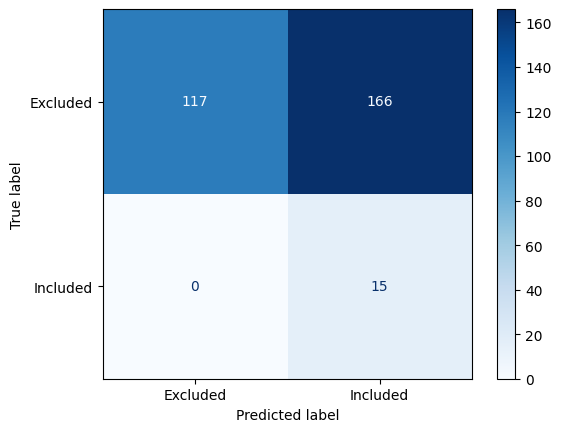

In [107]:
# Compare the model's labels with the human abstract labels
evaluate_prompt("Labels_Llama3_8b_11.xlsx", abs_benchmark)

# Attempt 12
Two-shot prompting

137.01445502500516 tokens per second


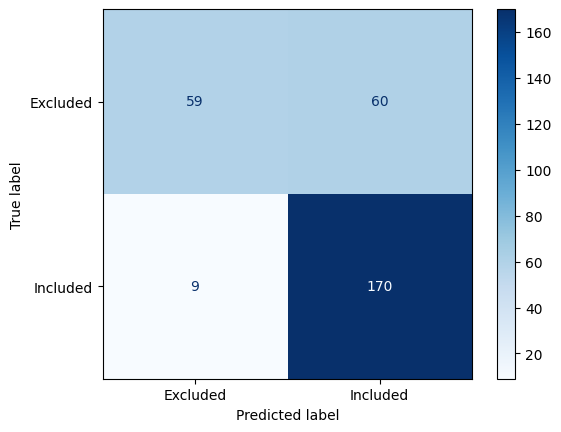

In [71]:
run_prompt(
    model = "llama3:8b", 
    prompt_file = "prompt12.txt", 
    df_in = test_df, 
    df_out = "Labels_Llama3_8b_12.xlsx", 
    options = {"seed": 42, "temperature": 0},  # for reproducible outputs, set temperature to 0 and seed to a number
    system = "Be conservative. If you find an ambiguous title, it is better to include it: I prefer including papers by mistake rather than excluding them by mistake. You want to have as little false negatives as possible. Step 1 has the priority over step 2."
    )

# Compare the model's labels with the human title labels
evaluate_prompt("Labels_Llama3_8b_12.xlsx", benchmark)

In [71]:
# Calculate te recall
get_recall("Labels_Llama3_8b_12.xlsx", benchmark)

0.9497206703910615

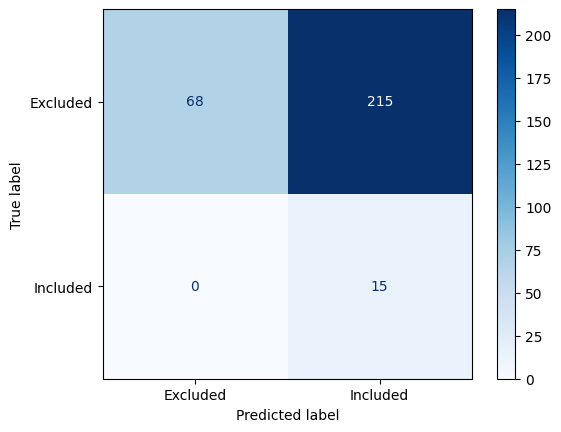

In [105]:
# Compare the model's labels with the human abstract labels
evaluate_prompt("Labels_Llama3_8b_12.xlsx", abs_benchmark)

# Attempt 13: 
Ask to use step by step reasoning. 

For this the "run_prompt" function needs to be changed.


In [14]:
# This function runs prompts that ask to label a test dataset and outputs the final labelled dataset
# https://github.com/ollama/ollama/blob/main/docs/api.md#generate-a-completion

def run_prompt(model, prompt_file, df_in, df_out, options=None, system=None, context=None, raw=False, keep_alive='5m'):

    # Empty list to store the response for each title
    responses = []

    # Load the prompt
    try:
        with open(prompt_file, 'r') as file:
            prompt = file.read()
    
    except FileNotFoundError:
        print(f"File '{prompt_file}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")
    
    file.close()

    # Copy the test dataset
    output_df = df_in

    # Run the prompt once for each title of the test dataset
    for title in test_df['title']:
        payload = {
            "model": model,
            "prompt": prompt + '"' + title + '"',
            "stream": False}

        # Include optional parameters if they are provided
        if options is not None:
            payload["options"] = options
        if system is not None:
            payload["system"] = system
        if context is not None:
            payload["context"] = context
        if raw is not False:
            payload["raw"] = True
        if keep_alive != '5m':
            payload["keep_alive"] = keep_alive

        # Sending the POST request
        response = requests.post(url, json=payload)

        # Append the response in the responses list
        responses.append(response.json()['response'])

    # Split the label part from the reasoning provided in the model response
    label = []
    for s in responses:
        if '#' in s:
            lbl = re.search('#(.*)#', s)
            label.append(lbl.group(1))
        else:
            label.append("Invalid format")
            
    # Add the reasonings and labels in the list in a new empty column of the output dataset
    output_df.loc[:,'reasoning'] = responses
    output_df.loc[:,'label'] = label

    # Save the labeled dataset 
    output_df.to_excel(df_out)

    # Calculate how fast the response is generated in tokens per second (token/s)
    time_to_respond = response.json()['eval_count'] / response.json()['eval_duration'] * 10**9

    print(time_to_respond, "tokens per second")

In [15]:
run_prompt(
    model = "llama3:8b", 
    prompt_file = "prompt13.txt", 
    df_in = test_df, 
    df_out = "Labels_Llama3_8b_13.xlsx", 
    options = {"seed": 42, "temperature": 0},  # for reproducible outputs, set temperature to 0 and seed to a number
    system = "Be conservative. If you find an ambiguous title, it is better to include it: I prefer including papers by mistake rather than excluding them by mistake. You want to have as little false negatives as possible. Step 1 has the priority over step 2."
    )

69.07454051797423 tokens per second


In [16]:
# Check how the reasonings look like in the output dataset
df13 = pd.read_excel("Labels_Llama3_8b_13.xlsx")
df13

,Unnamed: 0,MID,title,reasoning,label
0,0,M3062,Internet-based early intervention to prevent p...,Let's go through the steps:\n\nStep 1: Include...,1
1,1,M7694,Postdeployment suicidal ideations and trajecto...,"Step 1:\nThe title includes ""posttraumatic str...",1
2,2,M902,Maternal posttraumatic stress disorder symptom...,Let's go through the steps:\n\nStep 1:\nThe ti...,1
3,3,M6722,Trajectories of PTSD risk and resilience in Wo...,Let's go through the steps:\n\nStep 1:\nThe ti...,1
4,4,M11183,Latent trajectories of trauma symptoms and res...,"Step 1:\nThe title includes the concept ""traum...",1
...,...,...,...,...,...
293,293,M10369,Time-course analysis of frontal gene expressio...,"Based on Step 1, I would include this paper be...",0
294,294,M6107,Treatment outcomes of Veteran men in a compreh...,Let's go through the steps:\n\nStep 1:\nThe ti...,1
295,295,M10364,Altered Resting-State functional connectivity ...,"Step 1:\nThe title mentions ""Post-traumatic st...",1
296,296,M10348,Psychosocial and Physical Rehabilitation of Bu...,Let's go through the steps:\n\nStep 1: Include...,0


In [21]:
# Get an example of the reasoning
df13['reasoning'][1]

'Step 1:\nThe title includes "posttraumatic stress disorder" (PTSD), which is the specific topic of our systematic review. Additionally, it mentions "postdeployment suicidal ideations", which may be related to PTSD. The title also includes "danish soldiers", which suggests a population likely exposed to trauma.\n\nBased on Step 1, I would include this paper in our systematic review.\n\n#1#'

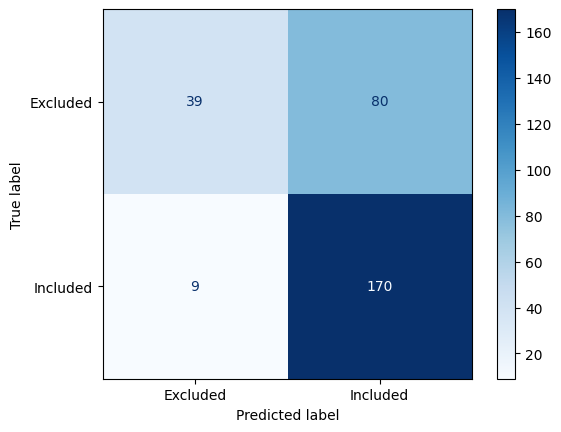

In [19]:
# Compare the model's labels with the human title labels
evaluate_prompt("Labels_Llama3_8b_13.xlsx", benchmark)

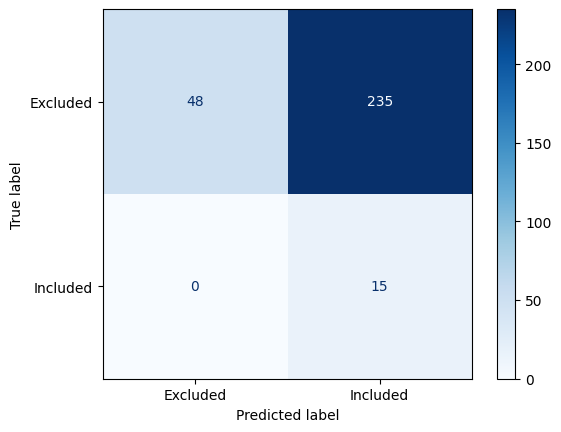

In [16]:
# Compare the model's labels with the human abstract labels
evaluate_prompt("Labels_Llama3_8b_13.xlsx", abs_benchmark)

# Attempt 14
Ask to use step by step reasoning, but eliminate "Step 1" and "Step 2" from the inclusion criteria, because ti might create confusion

In [22]:
run_prompt(
    model = "llama3:8b", 
    prompt_file = "prompt14.txt", 
    df_in = test_df, 
    df_out = "Labels_Llama3_8b_14.xlsx", 
    options = {"seed": 42, "temperature": 0},  # for reproducible outputs, set temperature to 0 and seed to a number
    system = "Be conservative. If you find an ambiguous title, it is better to include it: I prefer including papers by mistake rather than excluding them by mistake. You want to have as little false negatives as possible. Step 1 has the priority over step 2."
    )

68.83053678911214 tokens per second


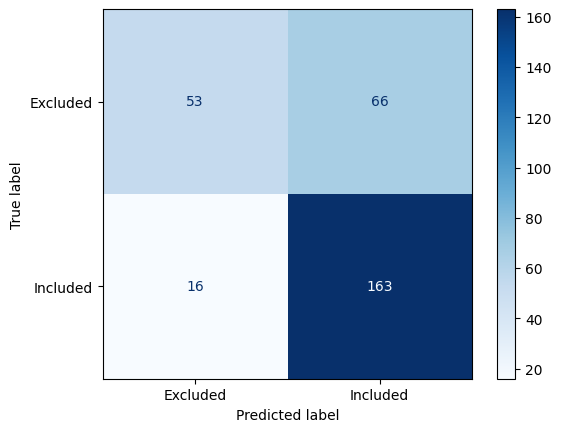

In [23]:
# Compare the model's labels with the human title labels
evaluate_prompt("Labels_Llama3_8b_14.xlsx", benchmark)

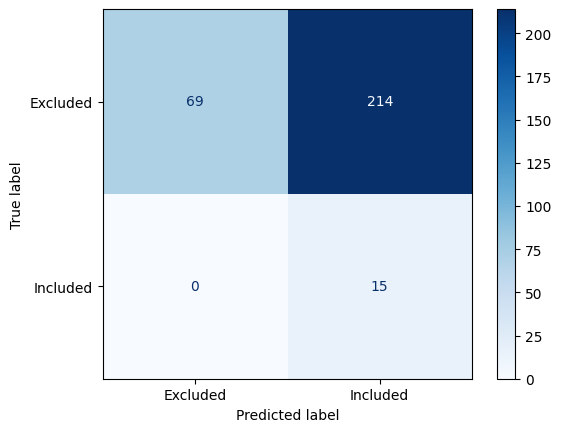

In [17]:
# Compare the model's labels with the human abstract labels
evaluate_prompt("Labels_Llama3_8b_14.xlsx", abs_benchmark)

# Attempt 15
Ask to reason based on the inclusion and exclusion criteria

In [25]:
run_prompt(
    model = "llama3:8b", 
    prompt_file = "prompt15.txt", 
    df_in = test_df, 
    df_out = "Labels_Llama3_8b_15.xlsx", 
    options = {"seed": 42, "temperature": 0},  # for reproducible outputs, set temperature to 0 and seed to a number
    system = "Be conservative. If you find an ambiguous title, it is better to include it: I prefer including papers by mistake rather than excluding them by mistake. You want to have as little false negatives as possible."
    )

68.07101462606936 tokens per second


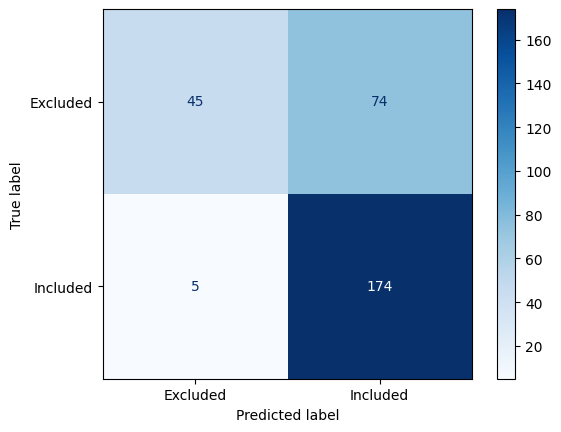

In [67]:
# Compare the model's labels with the human title labels
evaluate_prompt("Labels_Llama3_8b_15.xlsx", benchmark)

In [70]:
# Calculate the recall
get_recall("Labels_Llama3_8b_15.xlsx", benchmark)

0.9720670391061452

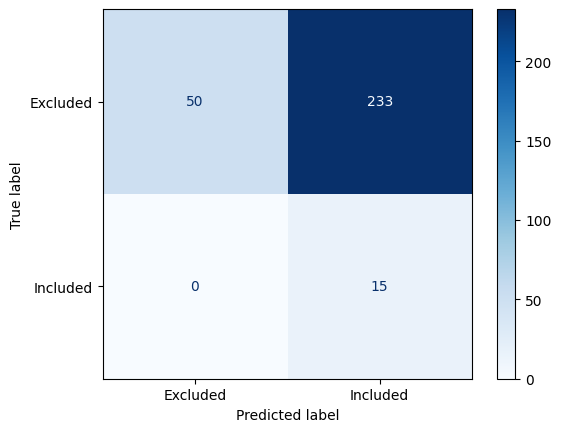

In [106]:
# Compare the model's labels with the human abstract labels
evaluate_prompt("Labels_Llama3_8b_15.xlsx", abs_benchmark)

# Attempt 16
Ask to use step by step reasoning both in the prompt and in the "system" parameter. 

For this task the "run_prompt" needs to be slightly changed.

In [59]:
# This function runs prompts that ask to label a test dataset and outputs the final labelled dataset
# https://github.com/ollama/ollama/blob/main/docs/api.md#generate-a-completion

def run_prompt(model, prompt_file, df_in, df_out, options=None, system=None, context=None, raw=False, keep_alive='5m'):

    # Empty list to store the response for each title
    responses = []

    # Load the prompt
    try:
        with open(prompt_file, 'r') as file:
            prompt = file.read()
    
    except FileNotFoundError:
        print(f"File '{prompt_file}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")
    
    file.close()

    # Copy the test dataset
    output_df = df_in

    # Run the prompt once for each title of the test dataset
    for title in test_df['title']:
        payload = {
            "model": model,
            "prompt": prompt + '"' + title + '"',
            "stream": False}

        # Include optional parameters if they are provided
        if options is not None:
            payload["options"] = options
        if system is not None:
            payload["system"] = system
        if context is not None:
            payload["context"] = context
        if raw is not False:
            payload["raw"] = True
        if keep_alive != '5m':
            payload["keep_alive"] = keep_alive

        # Sending the POST request
        response = requests.post(url, json=payload)

        # Append the response in the responses list
        responses.append(response.json()['response'])

    # Split the label part from the reasoning provided in the model response
    label = []
    for s in responses:
        if '##' in s:
            lbl = re.search('##(.*)##', s)
            label.append(lbl.group(1))
        else:
            label.append("Invalid format")
            
    # Add the reasonings and labels in the list in a new empty column of the output dataset
    output_df.loc[:,'reasoning'] = responses
    output_df.loc[:,'label'] = label

    # Save the labeled dataset 
    output_df.to_excel(df_out)

    # Calculate how fast the response is generated in tokens per second (token/s)
    time_to_respond = response.json()['eval_count'] / response.json()['eval_duration'] * 10**9

    print(time_to_respond, "tokens per second")

In [49]:
run_prompt(
    model = "llama3:8b", 
    prompt_file = "prompt16.txt", 
    df_in = test_df, 
    df_out = "Labels_Llama3_8b_16.xlsx", 
    options = {"seed": 42, "temperature": 0},  # for reproducible outputs, set temperature to 0 and seed to a number
    system = "Be conservative. If you find an ambiguous title, it is better to include it: I prefer including papers by mistake rather than excluding them by mistake. You want to have as little false negatives as possible. Use step by step reasoning."
    )

67.88879061776913 tokens per second


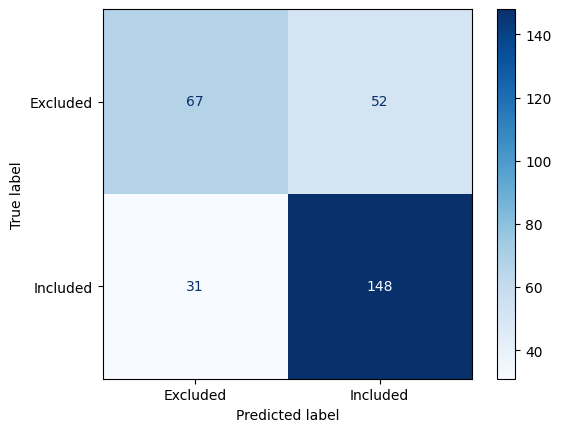

In [50]:
# Compare the model's labels with the human title labels
evaluate_prompt("Labels_Llama3_8b_16.xlsx", benchmark)

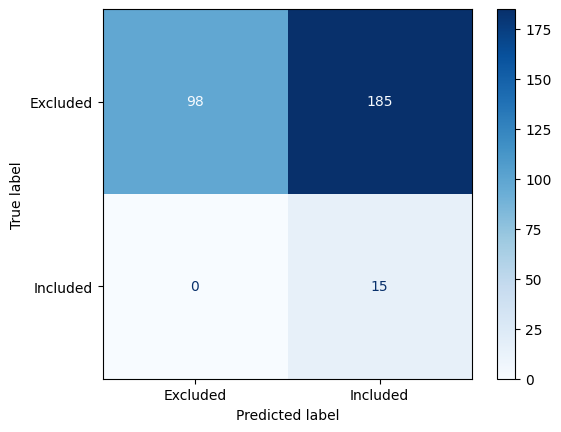

In [18]:
# Compare the model's labels with the human abstract labels
evaluate_prompt("Labels_Llama3_8b_16.xlsx", abs_benchmark)

# Attempt 17
Two-shot prompting + providing step by step reasoning in the two examples.

For this task the "run_prompt" function needs to be slightly changed.

In [ ]:
# This function runs prompts that ask to label a test dataset and outputs the final labelled dataset
# https://github.com/ollama/ollama/blob/main/docs/api.md#generate-a-completion

def run_prompt(model, prompt_file, df_in, df_out, options=None, system=None, context=None, raw=False, keep_alive='5m'):

    # Empty list to store the response for each title
    responses = []

    # Load the prompt
    try:
        with open(prompt_file, 'r') as file:
            prompt = file.read()
    
    except FileNotFoundError:
        print(f"File '{prompt_file}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")
    
    file.close()

    # Copy the test dataset
    output_df = df_in

    # Run the prompt once for each title of the test dataset
    for title in test_df['title']:
        payload = {
            "model": model,
            "prompt": prompt + '"' + title + '"',
            "stream": False}

        # Include optional parameters if they are provided
        if options is not None:
            payload["options"] = options
        if system is not None:
            payload["system"] = system
        if context is not None:
            payload["context"] = context
        if raw is not False:
            payload["raw"] = True
        if keep_alive != '5m':
            payload["keep_alive"] = keep_alive

        # Sending the POST request
        response = requests.post(url, json=payload)

        # Append the response in the responses list
        responses.append(response.json()['response'])

    # Split the label part from the reasoning provided in the model response
    label = []
    for s in responses:
        if '#' in s:
            lbl = re.search('#(.*)#', s)
            label.append(lbl.group(1))
        else:
            label.append("Invalid format")
            
    # Add the reasonings and labels in the list in a new empty column of the output dataset
    output_df.loc[:,'reasoning'] = responses
    output_df.loc[:,'label'] = label

    # Save the labeled dataset 
    output_df.to_excel(df_out)

    # Calculate how fast the response is generated in tokens per second (token/s)
    time_to_respond = response.json()['eval_count'] / response.json()['eval_duration'] * 10**9

    print(time_to_respond, "tokens per second")

In [119]:
run_prompt(
    model = "llama3:8b", 
    prompt_file = "prompt17.txt", 
    df_in = test_df, 
    df_out = "Labels_Llama3_8b_17.xlsx", 
    options = {"seed": 42, "temperature": 0,  # for reproducible outputs, set temperature to 0 and seed to a number
               "num_predict": -1},  # for infinite text generation 
    system = "Be conservative. If you find an ambiguous title, it is better to include it: I prefer including papers by mistake rather than excluding them by mistake. You want to have as little false negatives as possible. Step 1 has the priority over step 2."
    )

67.60611855859658 tokens per second


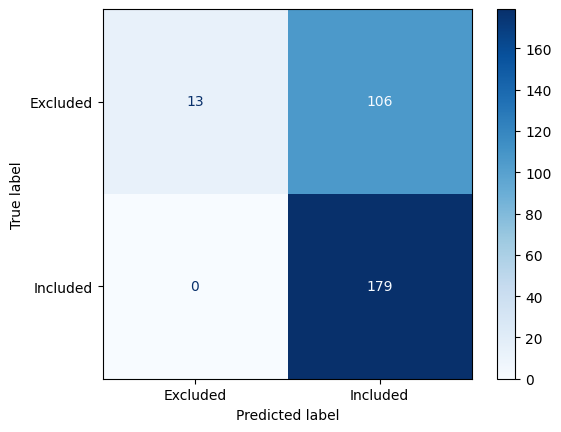

In [121]:
# Compare the model's labels with the human title labels
evaluate_prompt("Labels_Llama3_8b_17.xlsx", benchmark)

In [69]:
# Calculate the recall
get_recall("Labels_Llama3_8b_17.xlsx", benchmark)

1.0

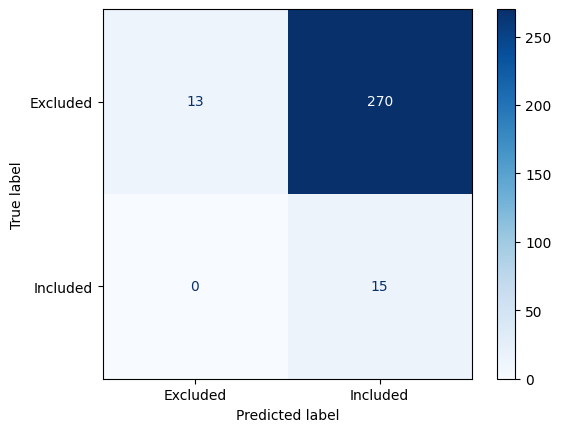

In [19]:
# Compare the model's labels with the human abstract labels
evaluate_prompt("Labels_Llama3_8b_17.xlsx", abs_benchmark)